<a href="https://colab.research.google.com/github/tangshuting/daytoy/blob/master/emw_adv_cleverhans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 参考链接 https://github.com/andantillon/fgsm_attack_guides_tf2.0/blob/master/Cleverhans_FGSM_attack.ipynb

In [1]:
pip install git+https://github.com/tensorflow/cleverhans.git#egg=cleverhans

  Cloning https://github.com/tensorflow/cleverhans.git to /tmp/pip-install-fm_uou_f/cleverhans
  Running command git clone -q https://github.com/tensorflow/cleverhans.git /tmp/pip-install-fm_uou_f/cleverhans
     |████████████████████████████████| 163kB 2.7MB/s 
     |████████████████████████████████| 51kB 5.7MB/s 
  Created wheel for cleverhans: filename=cleverhans-3.0.1-cp36-none-any.whl size=262573 sha256=a84ca2dfbda5c9ae57749fa8954998deb75cc67f8a424e18905f3cbc174197ee
  Stored in directory: /tmp/pip-ephem-wheel-cache-usi4hgcc/wheels/6e/59/ec/723a6f654aaf62c8c40f0f0850fdf71a4948598697f56c3bfa
Successfully built cleverhans


In [2]:
import cleverhans
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print("\nTensorflow Version: " + tf.__version__)
print("Cleverhans Version: " + cleverhans.__version__)
print("GPU Available: ", tf.test.is_gpu_available())


Tensorflow Version: 2.2.0
Cleverhans Version: 3.0.1-15447acccf2628751c1e44ee30e141ec
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  True


In [3]:
import pickle
from google.colab import drive
drive.mount('/content/drive')
f = open(r'/content/drive/My Drive/EMW/2016.04C.multisnr.pkl','rb') #open的参数是pkl文件的路径
Xd = pickle.load(f,encoding='bytes')
print(type(Xd))   # dict
print(len(Xd))  #220=11（类别）×20（20个snr）
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])  # set()创建一个无序的不重复元素序列
X = []
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr)) # append末尾添加对象
X = np.vstack(X)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'dict'>
220


In [4]:
np.random.seed(2016)
n_examples = X.shape[0]  # int 162060
n_train = n_examples * 0.5
train_idx = np.random.choice(range(0,n_examples), size= int(n_train), replace=False)  # ndarray with shape (81030,)
test_idx = list(set(range(0,n_examples))-set(train_idx))   # list (81030 items total)

X_train = X[train_idx]  # ndarray with shape (81030, 2, 128)
X_test =  X[test_idx]   # 同上
print(X_train.shape)

(81030, 2, 128)


In [ ]:
# print(lbl.shape) # AttributeError: 'list' object has no attribute 'shape' 解决办法是使用vstack函数
lbl_no = np.vstack(lbl)  # 这一步骤没必要，因为可以直接使用lbl去取出来调制方式
print(lbl_no)  # ndarray with shape (162060, 2)  [b'8PSK' b'-20']
Y_train_no = list(map(lambda x: mods.index(lbl[x][0]), train_idx))  # 显示的是1-11数字表示调制方式list (81030 items total)
print(Y_train_no[1])
Y_train_no = np.vstack(Y_train_no)  # # ndarray with shape (81030, 1)

Y_test_no = list(map(lambda x: mods.index(lbl[x][0]), test_idx))  
Y_test_no = np.vstack(Y_test_no) 

In [5]:
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1
Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))  # ndarray with shape (81030, 11)

In [ ]:
in_shp = list(X_train.shape[1:])   # list [2, 128]

classes = mods  # list [b'8PSK', b'AM-DSB', b'AM-SSB', b'BPSK', b'CPFSK', b'GFSK', b'PAM4', b'QAM16', b'QAM64', b'QPSK', b'WBFM'] (11 items total)

mods_str = []
for i in mods:
  mods_str.append(str(i).split('\'')[1])
print(mods_str)   # list ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
# print(Y_train[1])  # [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
# print(Y_train.shape)  # ndarray with shape (81030, 11)

In [24]:
num_classes = 11

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, input_shape=in_shp),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(135,activation=tf.nn.relu),
    tf.keras.layers.Dense(11),
    tf.keras.layers.Activation(tf.nn.softmax) # We seperate the activation layer to be able to access the logits of the previous layer later
])

model.compile(optimizer='adam',
              loss= 'categorical_crossentropy',
              metrics=['accuracy'])
# model.summary()

In [ ]:
nb_epoch = 100    # number of epochs to train on
batch_size = 1024  # training batch size
model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=2, validation_split=0.2)
# model.fit(X_train, Y_train,  epochs=nb_epoch, verbose=2, validation_split=0.2)

test_loss, test_acc = model.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc)

In [26]:
# Import the attack
from cleverhans.future.tf2.attacks import fast_gradient_method

#The attack requires the model to ouput the logits
logits_model = tf.keras.Model(model.input,model.layers[-1].output)

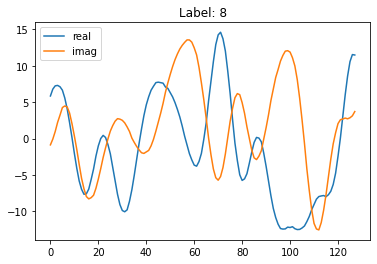

In [98]:
# 现在是随机选择一个无线电信号，后面重新固定SNR和调制方式进行选择
random_index = np.random.randint(X_test.shape[0])

original_image = X_test[random_index] # EagerTensor with shape (1, 2, 128)
original_image = tf.convert_to_tensor(original_image.reshape((1,2,128))) #The .reshape just gives it the proper form to input into the model, a batch of 1 a.k.a a tensor

original_label = Y_test_no[random_index]
original_label = np.reshape(original_label, (1,)).astype('int64')

#Show the image
plt.figure()
plt.grid(False)
original_image_plt = np.reshape(original_image, (2,128))
real = original_image_plt[0]  #取（2，128）的行
imag = original_image_plt[1]
# plt.axis([-1, 1, -1, 1])
plt.plot(real,label='real')
plt.plot(imag,label='imag')
# plt.imshow(np.reshape(original_image, (2,128)))
plt.title("Label: {}".format(original_label[0]))
plt.legend()  #设置 legend 图例

In [92]:
epsilon = 0.5

adv_example_untargeted_label = fast_gradient_method(logits_model, original_image, epsilon, np.inf, targeted=False)  # EagerTensor with shape (1, 2, 128)
example_untargeted_pred = model.predict(original_image) 
adv_example_untargeted_label_pred = model.predict(adv_example_untargeted_label)  # ndarray with shape (1, 11) 给出了11个概率

# print(adv_example_untargeted_label.shape)

print(max(example_untargeted_pred))
print(max(adv_example_untargeted_label_pred))

[0.06456616 0.05533943 0.09031989 0.17095913 0.1668472  0.13018136
 0.07986406 0.05453112 0.0209013  0.09671162 0.0697787 ]
[0.06456616 0.05533943 0.09031989 0.17095913 0.1668472  0.13018136
 0.07986406 0.05453112 0.0209013  0.09671162 0.0697787 ]


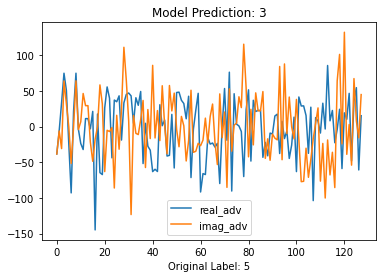

In [93]:

#Show the image
plt.figure()
plt.grid(False)

adv_example_untargeted_label_plt = np.reshape(adv_example_untargeted_label, (2,128))
real_adv = adv_example_untargeted_label_plt[0]  #取（2，128）的行
imag_adv = adv_example_untargeted_label_plt[1]
# plt.axis([-1, 1, -1, 1])

plt.plot(real_adv,label='real_adv')
plt.plot(imag_adv,label='imag_adv')

plt.title("Model Prediction: {}".format(np.argmax(adv_example_untargeted_label_pred)))
plt.xlabel("Original Label: {}".format(original_label[0]))
plt.legend()  #设置 legend 图例
plt.show()

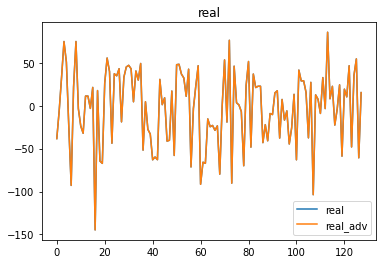

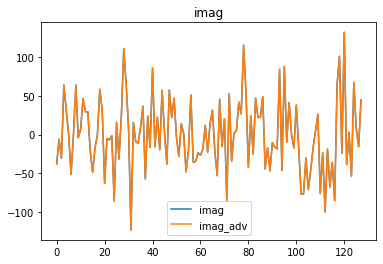

In [95]:
plt.figure()
plt.plot(real,label='real')
plt.plot(real_adv,label='real_adv')
plt.title("real")
plt.legend()  #设置 legend 图例
plt.figure()
plt.plot(imag,label='imag')
plt.plot(imag_adv,label='imag_adv')
plt.title("imag")

plt.legend()  #设置 legend 图例